### Imports, loading features and DB

In [1]:
# might not work in calc_det environment
from sklearnex import patch_sklearn
patch_sklearn("SVC")


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import sys
sys.path.insert(0, '..')

import operator as op
import pickle


In [3]:
from xgboost import XGBRFClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from metrics.metrics_utils import  get_froc_df_of_many_imgs_features
from mc_candidate_proposal.candidate_utils import balance_candidates
from general_utils.plots import plot_bboxes_over_image, plot_blobs, plot_blobs_2_sets
from metrics.metrics import froc_curve, froc_curve_bootstrap
from general_utils.plots import plot_froc, plot_bootstrap_froc
import seaborn as sns
from database.dataset import *

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

In [4]:
rseed = np.random.seed(42)

In [5]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['train', 'validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=False,
    ignore_diameter_px = 15
)

In [6]:
features_data = pd.read_feather('/home/vzalevskyi/projects/data/features/morph/cand_features_df.f')
fnsdf = pd.read_feather('/home/vzalevskyi/projects/data/features/morph/fns_df.f')
ignored = pd.read_feather('/home/vzalevskyi/projects/data/features/morph/ingnored_df.f')

In [7]:
print('Sensitivity over all mC (max sens value achived in froc without NMS) ',features_data.label.sum() / (features_data.label.sum() + len(fnsdf)))

Sensitivity over all mC (max sens value achived in froc without NMS)  0.8089813800657174


In [8]:
# retrieving each features set column names

fos_cols = [x for x in features_data if 'img' in x and x != 'img_id']
gabor_cols = [x for x in features_data if 'gabor_'in x]
wavelet_cols = [x for x in features_data if  x[:6] == 'patch_' and x != 'patch_coordinates']
haar_cols = [x for x in features_data if  'haar' in x]
features_sets = {'fos':fos_cols, 'gabor':gabor_cols, 'wavelet':wavelet_cols,
                 'haar':haar_cols,
                 'all_features':fos_cols+gabor_cols+wavelet_cols+haar_cols}

# Grid-Search

In [ ]:

param_grid = [
  {'SVC__C': [1, 10, 100], 'SVC__kernel': ['linear']},
  {'SVC__C': [1, 10, 100,], 'SVC__degree':[3, 5, 7, 10], 'SVC__kernel': ['poly']},
  {'SVC__C': [1, 10, 100,], 'SVC__gamma': [0.001, 0.01, 0.1, 1], 'SVC__kernel': ['rbf']},
 ]


pipe = Pipeline([('scaler', MinMaxScaler()), ('SVC', SVC())])


clf = GridSearchCV(estimator=pipe,
                   param_grid=param_grid,
                   scoring='roc_auc',
                   n_jobs=4,
                   cv=5)


FP2TP_rate = 10
positive_mask = (features_data.label>0)
positive_train_part = features_data[positive_mask]
negative_train_part = features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum())
train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)
train_y = train_df.label
train_X = train_df[features_sets['all_features']]

clf.fit(train_X, train_y)


In [ ]:
# with open('gsm_svc_fine_tuning.pkl', 'wb') as f:
#     pickle.dump(clf, f)

In [ ]:
clf.best_estimator_['SVC'].get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

# Cascade

### First Stage (removing easy negative)

In [9]:
clf = SVC(**{'C': 10,
            'break_ties': False,
            'cache_size': 200,
            'class_weight': None,
            'coef0': 0.0,
            'decision_function_shape': 'ovr',
            'degree': 3,
            'gamma': 0.1,
            'kernel': 'rbf',
            'max_iter': -1,
            'probability': True,
            'random_state': 42,
            'shrinking': True,
            'tol': 0.001,
            'verbose': False})

# clf = SVC(probability=True, random_state=42)

In [10]:
# adding case_id column for case_wise K-fold CV splits
imgid2caseid = db.df[['img_id', 'case_id']].set_index('img_id').to_dict()['case_id']
features_data['case_id'] = [imgid2caseid[imgid] for imgid in features_data['img_id']]

In [11]:
# splitting all candidates between db train and validation partitions

all_train_db_ids = db.df[db.df.partition == 'train'].img_id.values
all_valid_db_ids = db.df[db.df.partition == 'validation'].img_id.values

general_train_mask = features_data.img_id.isin(all_train_db_ids)
general_valid_mask = features_data.img_id.isin(all_valid_db_ids)

train_features = features_data[general_train_mask]
test_features = features_data[general_valid_mask]

In [12]:
kfolds = 5
FP2TP_rate = 10

features = features_sets['all_features']
# splitting data into train/validation case-wise
all_train_case_ids = train_features.case_id.unique()
kfolds_case_splits = np.array_split(all_train_case_ids, kfolds)

predicted_test_df = []
balanced_train_df = []

# kfold CV
for valid_case_ids in tqdm(kfolds_case_splits):
    
    # split data into test
    test_split_mask = train_features.case_id.isin(valid_case_ids)
    
    # split into train and take into account cleaned data with no mC in the borders of the patch
    cleaned_features_data = train_features[~test_split_mask]
    
    # and sampling to a predefined 1:FP2TP_rate TP:FP samples
    positive_mask = (cleaned_features_data.label>0)
    positive_train_part = cleaned_features_data[positive_mask]
    negative_train_part = cleaned_features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum())
    
    
    train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)

    test_df = train_features[test_split_mask]
    
    train_y = train_df.label
    test_y = test_df.label
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_df[features].values)
    test_X_scaled = scaler.transform(test_df[features].values)
    
    clf.fit(train_X_scaled, train_y)

    train_y_predicted = clf.predict_proba(train_X_scaled)[:,1]
    test_y_predicted = clf.predict_proba(test_X_scaled)[:,1]
    
    test_df['cv_fold_predict_proba'] = test_y_predicted
    predicted_test_df.append(test_df)


  0%|          | 0/5 [00:00<?, ?it/s]INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
/tmp/ipykernel_220314/619723861.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cv_fold_predict_proba'] = test_y_predicted
 20%|██        | 1/5 [00:20<01:20, 20.08s/it]INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC

In [13]:
predicted_test_df = pd.concat(predicted_test_df)

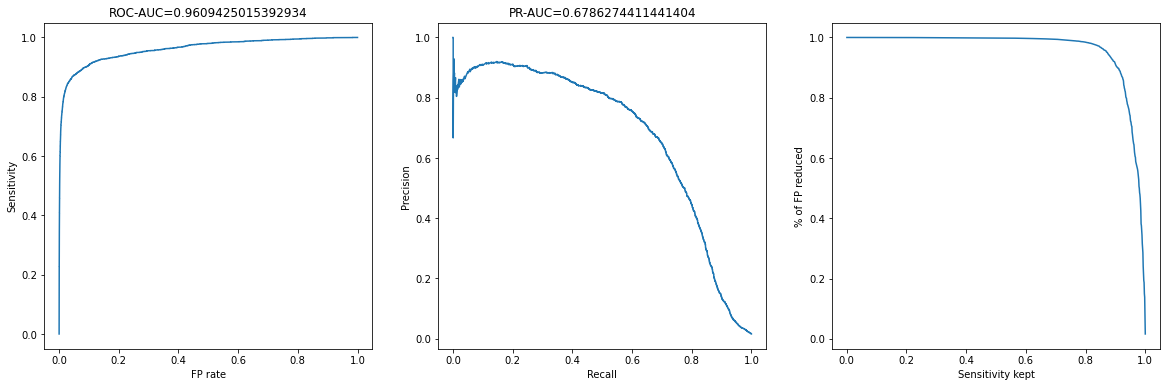

In [14]:
fpr, tpr, thrs = roc_curve(predicted_test_df.label, predicted_test_df.cv_fold_predict_proba)

prc, rc, thrs_pr = precision_recall_curve(predicted_test_df.label, predicted_test_df.cv_fold_predict_proba)

filtered_fp_prc = []
total_fp = np.sum(~predicted_test_df.label)
for ks in np.linspace(0.001,1,num=1000):

    keep_sens_thr = ks
    max_conf_thr_required = thrs[np.argmax(tpr>=keep_sens_thr)]

    filtered_fp = np.sum((~predicted_test_df.label) & (predicted_test_df.cv_fold_predict_proba <= max_conf_thr_required))/total_fp
    filtered_fp_prc.append(filtered_fp)



fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(fpr, tpr)
axs[0].set_xlabel('FP rate')
axs[0].set_ylabel('Sensitivity')
axs[0].set_title(f'ROC-AUC={roc_auc_score(predicted_test_df.label, predicted_test_df.cv_fold_predict_proba)}')

axs[1].plot(rc, prc)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'PR-AUC={auc(rc, prc)}')

axs[2].plot(np.linspace(0.001,1,num=1000), filtered_fp_prc)
axs[2].set_xlabel('Sensitivity kept')
axs[2].set_ylabel('% of FP reduced')
plt.show()

In [15]:
keep_sens_thr = .98
max_conf_thr_required = thrs[np.argmax(tpr>=keep_sens_thr)]

filtered_fp = np.sum((~predicted_test_df.label) & (predicted_test_df.cv_fold_predict_proba <= max_conf_thr_required))/total_fp
filtered_fp

0.499711910857704

Training final first stage model



In [16]:
# and sampling to a predefined 1:FP2TP_rate TP:FP samples
positive_mask = (train_features.label>0)
positive_train_part = train_features[positive_mask]
negative_train_part = train_features[~positive_mask].sample(FP2TP_rate*positive_mask.sum())


train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)

first_stage_model = Pipeline([('scaler', MinMaxScaler()), ('svc', clf)])
first_stage_model.fit(train_df[features], train_df.label)

INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svc',
                 SVC(C=10, gamma=0.1, probability=True, random_state=42))])

### Second Stage (retraining on harder samples)

In [18]:
print(max_conf_thr_required)
train_df_stage2 = predicted_test_df[predicted_test_df.cv_fold_predict_proba > max_conf_thr_required]

0.003795811478854027


In [20]:
print(len(predicted_test_df), len(train_df_stage2))


202729 102928


In [21]:
kfolds = 5
FP2TP_rate = 10

features = features_sets['all_features']
# splitting data into train/validation case-wise
all_train_case_ids = train_df_stage2.case_id.unique()
kfolds_case_splits = np.array_split(all_train_case_ids, kfolds)

predicted_test_df2 = []

# kfold CV
for valid_case_ids in tqdm(kfolds_case_splits):
    
    # split data into test
    test_split_mask = train_df_stage2.case_id.isin(valid_case_ids)
    
    # split into train and take into account cleaned data with no mC in the borders of the patch
    cleaned_features_data = train_df_stage2[~test_split_mask]
    
    # and sampling to a predefined 1:FP2TP_rate TP:FP samples
    positive_mask = (cleaned_features_data.label>0)
    positive_train_part = cleaned_features_data[positive_mask]
    negative_train_part = cleaned_features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum())
    
    
    train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)
    
    test_df = train_df_stage2[test_split_mask]
    
    train_y = train_df.label
    test_y = test_df.label
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_df[features].values)
    test_X_scaled = scaler.transform(test_df[features].values)
    
    clf.fit(train_X_scaled, train_y)

    train_y_predicted = clf.predict_proba(train_X_scaled)[:,1]
    test_y_predicted = clf.predict_proba(test_X_scaled)[:,1]
    
    test_df['cv_fold_predict_proba'] = test_y_predicted
    predicted_test_df2.append(test_df)


  0%|          | 0/5 [00:00<?, ?it/s]INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
/tmp/ipykernel_220314/2142602122.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cv_fold_predict_proba'] = test_y_predicted
 20%|██        | 1/5 [00:18<01:12, 18.07s/it]INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SV

In [22]:
predicted_test_df2 = pd.concat(predicted_test_df2)

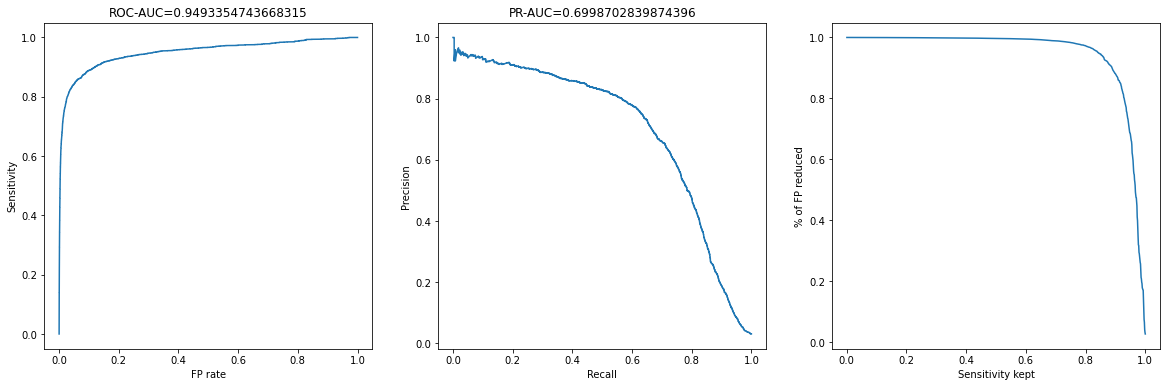

In [23]:
fpr, tpr, thrs = roc_curve(predicted_test_df2.label, predicted_test_df2.cv_fold_predict_proba)

prc, rc, thrs_pr = precision_recall_curve(predicted_test_df2.label, predicted_test_df2.cv_fold_predict_proba)

filtered_fp_prc = []
total_fp = np.sum(~predicted_test_df2.label)
for ks in np.linspace(0.001,1,num=1000):

    keep_sens_thr = ks
    max_conf_thr_required = thrs[np.argmax(tpr>=keep_sens_thr)]

    filtered_fp = np.sum((~predicted_test_df2.label) & (predicted_test_df2.cv_fold_predict_proba <= max_conf_thr_required))/total_fp
    filtered_fp_prc.append(filtered_fp)



fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(fpr, tpr)
axs[0].set_xlabel('FP rate')
axs[0].set_ylabel('Sensitivity')
axs[0].set_title(f'ROC-AUC={roc_auc_score(predicted_test_df2.label, predicted_test_df2.cv_fold_predict_proba)}')

axs[1].plot(rc, prc)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'PR-AUC={auc(rc, prc)}')

axs[2].plot(np.linspace(0.001,1,num=1000), filtered_fp_prc)
axs[2].set_xlabel('Sensitivity kept')
axs[2].set_ylabel('% of FP reduced')
plt.show()

In [24]:
# and sampling to a predefined 1:FP2TP_rate TP:FP samples
positive_mask = (train_df_stage2.label>0)
positive_train_part = train_df_stage2[positive_mask]
negative_train_part = train_df_stage2[~positive_mask].sample(FP2TP_rate*positive_mask.sum())


train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)

second_stage_model = Pipeline([('scaler', MinMaxScaler()), ('svc', clf)])
second_stage_model.fit(train_df[features], train_df.label)

INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svc',
                 SVC(C=10, gamma=0.1, probability=True, random_state=42))])

In [72]:
train_df_stage2.label.sum()/len(train_df_stage2)

0.029875252603761854

### Final comparison between clssifiers

In [25]:
val1st_pred = first_stage_model.predict_proba(test_features[features])[:,1]
val2st_pred = second_stage_model.predict_proba(test_features[features])[:,1]

INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU


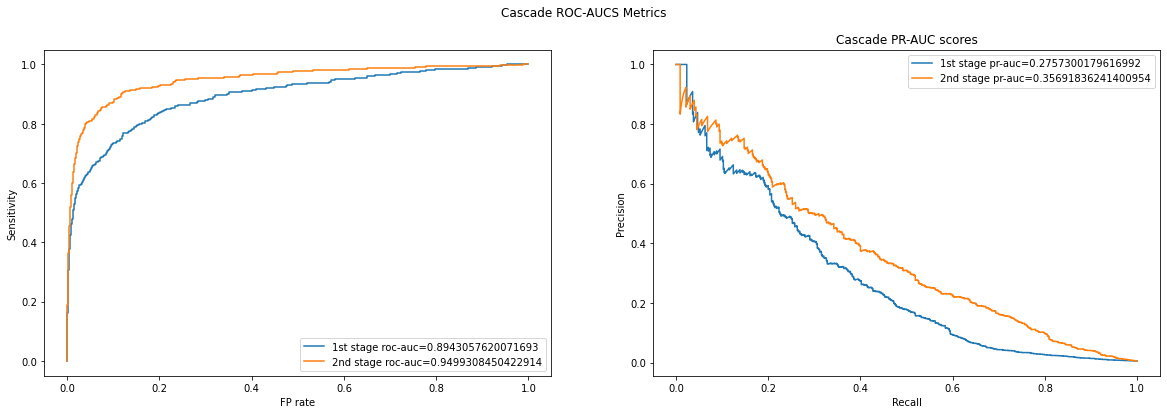

In [26]:
fpr_train1, tpr_train1, _ = roc_curve(test_features.label, val1st_pred)
prc_train1, rc_train1, _ = precision_recall_curve(test_features.label, val1st_pred)

fpr_test2, tpr_test2, _ = roc_curve(test_features.label, val2st_pred)
prc_test2, rc_test2, _ = precision_recall_curve(test_features.label, val2st_pred)


fig, axs = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Cascade ROC-AUCS Metrics')
axs[0].plot(fpr_train1, tpr_train1)
axs[0].plot(fpr_test2, tpr_test2)
axs[0].set_xlabel('FP rate')
axs[0].set_ylabel('Sensitivity')
axs[0].legend([f'1st stage roc-auc={roc_auc_score(test_features.label, val1st_pred, )}',
               f'2nd stage roc-auc={roc_auc_score(test_features.label, val2st_pred)}'])

axs[1].plot(rc_train1, prc_train1)
axs[1].plot(rc_test2, prc_test2)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'Cascade PR-AUC scores')
axs[1].legend([f'1st stage pr-auc={auc(rc_train1, prc_train1)}',
               f'2nd stage pr-auc={auc(rc_test2, prc_test2)}'])


plt.show()


In [27]:
valid_fnsdf = fnsdf[fnsdf.img_id.isin(test_features.img_id.unique())]

In [28]:
normal_imgs_ids = db.get_normal_imgs_ids()


froc_df_1st = get_froc_df_of_many_imgs_features(
    test_features[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    valid_fnsdf,
    val1st_pred,
    normal_imgs_ids
)

sens1, avgs_fp_per_image1, _ = froc_curve(froc_df_1st, non_max_supression=True, cut_on_50fpi=True)


froc_df_2st = get_froc_df_of_many_imgs_features(
    test_features[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    valid_fnsdf,
    val2st_pred,
    normal_imgs_ids
)

sens2, avgs_fp_per_image2, _ = froc_curve(froc_df_2st, non_max_supression=True, cut_on_50fpi=True)

/home/vzalevskyi/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/vzalevskyi/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


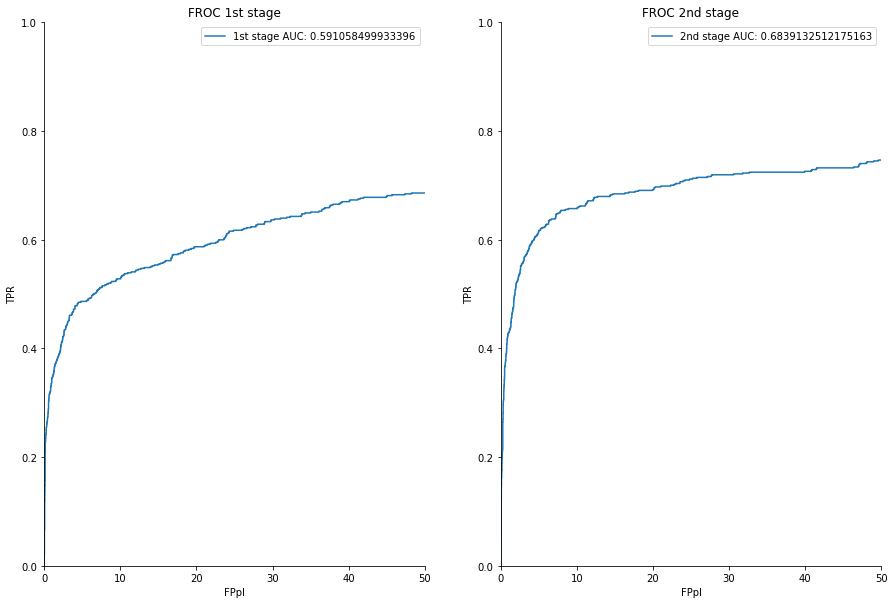

In [29]:

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
plot_froc(avgs_fp_per_image1, sens1, label='1st stage', title='FROC 1st stage', cut_on_50fpi=True, ax=axs[0])




plot_froc(avgs_fp_per_image2, sens2, label='2nd stage', title='FROC 2nd stage', cut_on_50fpi=True, ax=axs[1])

# Removing bad labels

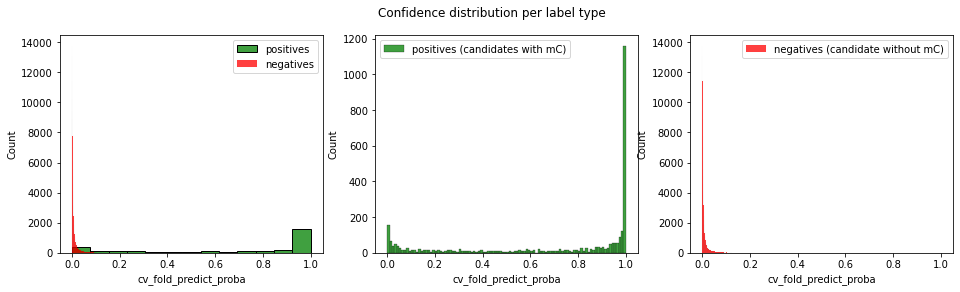

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

fig.suptitle('Confidence distribution per label type')

sns.histplot(predicted_test_df[predicted_test_df.label].cv_fold_predict_proba, color='g', ax=axs[0])
sns.histplot(predicted_test_df[~predicted_test_df.label].cv_fold_predict_proba, color='r', ax=axs[0])
axs[0].legend(['positives', 'negatives'])

sns.histplot(predicted_test_df[predicted_test_df.label].cv_fold_predict_proba, color='g', bins=100, ax=axs[1])
axs[1].legend(['positives (candidates with mC)'])

sns.histplot(predicted_test_df[~predicted_test_df.label].cv_fold_predict_proba, color='r', ax=axs[2])
axs[2].legend(['negatives (candidate without mC)'])

plt.show()

<AxesSubplot:xlabel='cv_fold_predict_proba', ylabel='Count'>

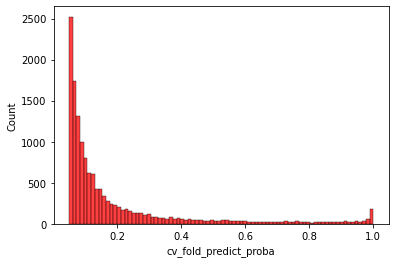

In [31]:
sns.histplot(predicted_test_df[(~predicted_test_df.label)&(predicted_test_df.cv_fold_predict_proba > 0.05)].cv_fold_predict_proba, color='r')

In [32]:
remove_pos_thr = 0.4
remove_neg_thr = 0.6

good_positives = (predicted_test_df.label)&(predicted_test_df.cv_fold_predict_proba > remove_pos_thr)
good_negatives = (~predicted_test_df.label)&(predicted_test_df.cv_fold_predict_proba < remove_neg_thr)

cleaned_train_df = predicted_test_df[good_positives|good_negatives]

print(len(cleaned_train_df)/len(predicted_test_df))

0.9909090460664236


In [33]:
positive_mask = (cleaned_train_df.label>0)
positive_train_part = cleaned_train_df[positive_mask]
negative_train_part = cleaned_train_df[~positive_mask].sample(FP2TP_rate*positive_mask.sum())


train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)

cleaned_data_model = Pipeline([('scaler', MinMaxScaler()), ('svc', clf)])
cleaned_data_model.fit(train_df[features], train_df.label)

INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svc',
                 SVC(C=10, gamma=0.1, probability=True, random_state=42))])

In [34]:
cleaned_data_model_pred = cleaned_data_model.predict_proba(test_features[features])[:,1]

INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU


/home/vzalevskyi/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


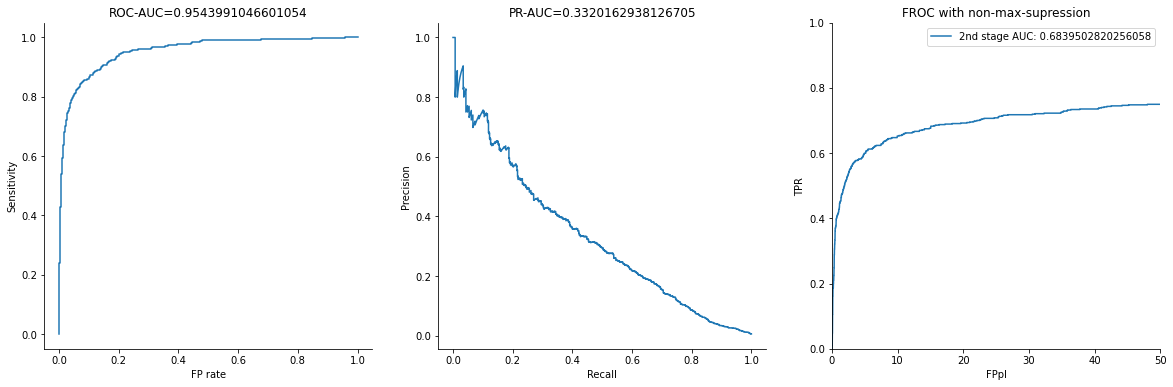

In [35]:
fpr, tpr, thrs = roc_curve(test_features.label, cleaned_data_model_pred)

prc, rc, thrs_pr = precision_recall_curve(test_features.label,cleaned_data_model_pred)



froc_df_1st = get_froc_df_of_many_imgs_features(
    test_features[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    valid_fnsdf,
    cleaned_data_model_pred,
    normal_imgs_ids
)

sens1, avgs_fp_per_image1, _ = froc_curve(froc_df_1st, non_max_supression=True, cut_on_50fpi=True)





fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(fpr, tpr)
axs[0].set_xlabel('FP rate')
axs[0].set_ylabel('Sensitivity')
axs[0].set_title(f'ROC-AUC={roc_auc_score(test_features.label, cleaned_data_model_pred)}')

axs[1].plot(rc, prc)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'PR-AUC={auc(rc, prc)}')

plot_froc(avgs_fp_per_image1, sens1, label='2nd stage', title='FROC with non-max-supression', cut_on_50fpi=True, ax=axs[2])

plt.show()

# Looking into bad results

In [36]:
test_features['confidence'] = val2st_pred

test_df = test_features

/tmp/ipykernel_220314/2031025059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features['confidence'] = val2st_pred


In [37]:
bad_res_FP = test_df[~test_df.label].sort_values(by=['confidence'], ascending=False).drop(columns=features_sets['all_features'])
bad_res_FN = test_df[test_df.label].sort_values(by=['confidence'], ascending=True).drop(columns=features_sets['all_features'])

bad_res_FN_normals = bad_res_FN[bad_res_FN.img_id.isin(db.get_normal_imgs_ids())]
bad_res_FP_normals = bad_res_FP[bad_res_FP.img_id.isin(db.get_normal_imgs_ids())]


for _, bad_res in tqdm(bad_res_FN.head(100).iterrows(), total=100):
    img_id = bad_res['img_id']
    test_img_id = db.df[db.df.img_id == img_id].index.values[0] #((2767, 2781), (1029, 1043))	
    test_img = db[test_img_id]['img']
    test_mask = db[test_img_id]['lesion_mask']
    
    original_test_mask = cv2.imread(str(db.full_mask_path/f'{img_id}_lesion_mask.png'), cv2.IMREAD_GRAYSCALE)
    (ppx1, ppx2), (ppy1, ppy2)= bad_res['patch_coordinates']

    if original_test_mask is not None:
        fig, axs = plt.subplots(4,3, figsize=(20, 8))
        if db.img_df[db.img_df.img_id == img_id]['side'].values[0] == "R":
            original_test_mask = cv2.flip(original_test_mask, 1)
    else:
        fig, axs = plt.subplots(4,2, figsize=(20, 8))
    for didx, delta in enumerate([0, 10, 50, 100]):
        axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,  ppy1-delta:ppy2+delta], cmap='gray')
        axs[didx, 0].axis('off')
        axs[didx, 0].set_title(f'Original zoom=-{delta}')

        axs[didx, 1].imshow(test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta], cmap='gray', vmin=0)
        axs[didx, 1].axis('off')
        axs[didx, 1].set_title(f'INBreast DB mask zoom=-{delta}')
        if original_test_mask is not None:
            axs[didx, 2].imshow(original_test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta]>0, cmap='gray', vmin=0)
            axs[didx, 2].axis('off')
            axs[didx, 2].set_title(f'Original DB mask zoom=-{delta}')
    plt.savefig(f'bad_res_FN/conf={bad_res["confidence"]}_{img_id}_{_}.jpg', bbox_inches="tight", dpi=600, pad_inches=0, transparent=False)
    plt.close(fig)

  5%|▌         | 5/100 [00:10<03:09,  2.00s/it]/tmp/ipykernel_112095/3175446880.py:24: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,  ppy1-delta:ppy2+delta], cmap='gray')
/tmp/ipykernel_112095/3175446880.py:28: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 1].imshow(test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta], cmap='gray', vmin=0)
/tmp/ipykernel_112095/3175446880.py:32: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  axs[didx, 2].imshow(original_test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta]>0, cmap='gray', vmin=0)
100%|██████████| 100/100 [03:32<00:00,  2.12s/it]


In [63]:
for img_id in tqdm(test_features.img_id.unique()):
    test_img_id = db.df[db.df.img_id == img_id].index.values[0] #((2767, 2781), (1029, 1043))	
    test_img = db[test_img_id]['img']
    
    fn_cand = fnsdf[fnsdf.img_id == img_id][['x', 'y', 'radius']].values.astype(int)
    tp_can = test_features[(test_features.img_id == img_id)&(test_features.label)&(test_features.confidence>=0.5)]
    fn_extra_can = test_features[(test_features.img_id == img_id)&(test_features.label)&(test_features.confidence<0.5)]
    fp_extra_can = test_features[(test_features.img_id == img_id)&(~test_features.label)&(test_features.confidence>=0.5)]
    
    tp_can_coords = np.stack(tp_can.patch_coordinates.values) if len(tp_can) else []
    fn_extra_can_coords = np.stack(fn_extra_can.patch_coordinates.values) if len(fn_extra_can) else []
    fp_extra_can_coords = np.stack(fp_extra_can.patch_coordinates) if len(fp_extra_can) else []
        
    res_img = plot_bboxes_over_image(test_img,
                                     [fn_cand, tp_can_coords],
                                     [(0, 0, 255), (0, 255, 0)], 
                                     ['circ', 'rect'],
                                     )
    
    cv2.imwrite(f'/home/vzalevskyi/projects/data/detection_results/{img_id}.png', res_img)
    plt.close()

 26%|██▌       | 16/62 [00:07<00:21,  2.17it/s]


KeyboardInterrupt: 

In [ ]:
cv2.rectangle()

In [70]:
tp_can

,haar_0,haar_1,haar_2,haar_3,haar_4,haar_5,haar_6,haar_7,haar_8,haar_9,...,patch_glcm_dissimilarity_HH1_1,patch_glcm_dissimilarity_HH1_2,candidate_coordinates,patch_coordinates,img_id,repeted_idxs,matching_gt,label,case_id,confidence
94394,-0.259922,-0.49902,0.205781,0.44929,0.380451,-0.540176,0.27462,0.362812,0.545566,-0.301078,...,76.25,62.257143,"[1606, 2075, 3]","[[2068, 2082], [1599, 1613]]",24055877,0.0,1.0,True,839819f2eadaf325,0.961671


In [61]:
    res_img = plot_bboxes_over_image(test_img,
                                     [fn_cand, tp_can_coords, fn_extra_can_coords, fp_extra_can_coords],
                                     [(0, 0, 255), (0, 255, 0), (0, 137, 255), (52, 235, 204)], 
                                     ['circ', 'rect', 'rect', 'rect'],
                                     )

array([[ 790., 2008.,    0.],
       [ 526.,  706.,    0.],
       [ 532.,  222.,    0.],
       [ 541.,  225.,    0.],
       [  89., 2847.,    0.]])

In [ ]:
# text=[['not_detected']*len(fn_cand),
#                                            tp_can.confidence.astype(str),
#                                            fn_extra_can.confidence.astype(str),
#                                            fp_extra_can.confidence.astype(str),
#                                            ]

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import auc
from matplotlib.lines import Line2D
from scipy.ndimage.morphology import binary_fill_holes
from feature_extraction.haar_features.haar_modules import Feature
import general_utils.utils as utils

def plot_blobs_2_sets(
    image: np.ndarray, blobs_a: np.ndarray, blobs_b: np.ndarray, ax=None,
    label_a: str = 'set 1', label_b: str = 'set 2'
):
    """Overlay two sets of blob circles over the image.
    Args:
        image (np.ndarray): image to which overlay the blobs
        blobs_a (np.ndarray): blobs to overlay over the image in red
            each row is a candidate (x, y, radius)
        blobs_b (np.ndarray): blobs to overlay over the image in green.
            each row is a candidate (x, y, radius)
        ax (ax element, optional): To use in subplots. Defaults to None.
        label_a (str, optional): Name for the first set. Defaults to 'set 1'.
        label_b (str, optional): Name for the second set. Defaults to 'set 2'.
    """
    legend_elements = [
        Line2D(
            [0], [0], marker='o', ls='None', c='w', label=label_a, mfc='k', mec='r', ms=10, mew=2),
        Line2D(
            [0], [0], marker='o', ls='None', c='w', label=label_b, mfc='k', mec='g', ms=10, mew=2)
    ]
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(20, 20))
    # image = min_max_norm(image, 255)
    image = image.astype('uint8')
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for blob in blobs_a:
        x, y, r = blob
        x, y = int(x), int(y)
        image = cv2.circle(
            image, (x, y), int(math.sqrt(2) * r)+10, (255, 0, 0), 2
        )
    for blob in blobs_b:
        x, y, r = blob
        x, y = int(x), int(y)
        image = cv2.circle(
            image, (x, y), int(math.sqrt(2) * r)+25, (0, 255, 0), 2
        )
    return image

In [52]:


def plot_bboxes_over_image(image, bboxes, colors, types, text=None, thickness=2, alpha=0.2):
    """Overimposes bboxes on the image. Can work with multiple groups and types of bboxes.
    Args:
        image (np.ndarray): Single channel grayscale image for overimposition.
        bboxes (list[np.ndarray]): List of bboxes. Each element of the list
            should have one of the specific shapes depending of bbox type:
                (n_bboxes, top_left_coord, top_right_coordinate) - 'rect' type, where
                    top_left_coord, top_right_coordinate - are tuples with 2 integer coords
                (n_bboxes, centre_x, centre_y, radius) - 'circ' type
                    center coordinates - and radiuses should be integers
        colors (list[tuple]): List of colors to be assigned to the bboxes. In BGR convention.
        types (list[str]): List of bbox types: 'rect' OR 'circ'.
        thickness (int, optional): Bbox plot thickness. Defaults to 2.
        alpha (float, optional): Transparency of the bboxes. Defaults to 0.2.

    Returns:
        np.ndaray: 3 channel colored image with overimposed bboxes
    """
    img_bgr = (255*(image/image.max())).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2RGB)

    for bbox_group_idx, bbox_group in enumerate(bboxes):
        bbox_mask = np.zeros_like(img_bgr, dtype=np.uint8)
        for bbox_idx, bbox in enumerate(bbox_group):
            if types[bbox_group_idx] == 'rect':
                bbox_mask = cv2.rectangle(bbox_mask, bbox[0], bbox[1],
                                          color=colors[bbox_group_idx],
                                          thickness=thickness)
            elif types[bbox_group_idx] == 'circ':
                bbox_mask = cv2.circle(bbox_mask, (bbox[0], bbox[1]),
                                       bbox[2], color=colors[bbox_group_idx],
                                       thickness=thickness)
            if text is not None:
                cv2.putText(img=img_bgr, text=text[bbox_group_idx][bbox_group_idx], org=(bbox[0]-3, bbox[1]-3), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=3, color=(0, 255, 0),thickness=3)

        beta = 1 - alpha
        img_bgr = cv2.addWeighted(img_bgr, beta, bbox_mask, alpha, 0.0)
    return img_bgr
